<a href="https://colab.research.google.com/github/DenisOgr/kaggle-experiments/blob/master/PytorchRNNFromScratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import glob
import os
import unicodedata
import string
import torch
from torch import nn
import random
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker


## Data

In [0]:
#Download
#Read to dict (lang: list of names). Converted to ASCII

In [11]:
!mkdir /content/data
!wget https://download.pytorch.org/tutorial/data.zip -P /content/data
!unzip -o -d /content/data/ /content/data/data.zip 

mkdir: cannot create directory ‘/content/data’: File exists
--2020-03-01 16:11:30--  https://download.pytorch.org/tutorial/data.zip
Resolving download.pytorch.org (download.pytorch.org)... 99.84.168.83, 99.84.168.27, 99.84.168.110, ...
Connecting to download.pytorch.org (download.pytorch.org)|99.84.168.83|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2882130 (2.7M) [application/zip]
Saving to: ‘/content/data/data.zip.1’

data.zip.1          100%[===================>]   2.75M  --.-KB/s    in 0.1s    

2020-03-01 16:11:31 (18.4 MB/s) - ‘/content/data/data.zip.1’ saved [2882130/2882130]

Archive:  /content/data/data.zip
  inflating: /content/data/data/eng-fra.txt  
  inflating: /content/data/data/names/Arabic.txt  
  inflating: /content/data/data/names/Chinese.txt  
  inflating: /content/data/data/names/Czech.txt  
  inflating: /content/data/data/names/Dutch.txt  
  inflating: /content/data/data/names/English.txt  
  inflating: /content/data/data/names/French.t

In [0]:
all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )
def files_to_dataset(path_to_files): 
  all_categories = {}   
  for file in glob.glob(path_to_files):
    cat = os.path.basename(file).split('.')[0].lower()
    list_of_names = [unicodeToAscii(line.rstrip()) for line in open(file).readlines()]
    all_categories[cat] = list_of_names
  return all_categories

all_categories = files_to_dataset('/content/data/data/names/*')
all_categories_names = list(all_categories.keys())
hidden_size=128
n_categories = len(all_categories_names)

In [13]:
print('Number of categories: ', len(all_categories.keys()))
print('Categories: ', all_categories_names)

Number of categories:  18
Categories:  ['portuguese', 'scottish', 'polish', 'english', 'chinese', 'greek', 'russian', 'italian', 'spanish', 'arabic', 'japanese', 'korean', 'dutch', 'german', 'vietnamese', 'czech', 'irish', 'french']


In [25]:
len(all_categories['german'])

724

In [0]:
all_categories['arabic'][:10]

['Khoury',
 'Nahas',
 'Daher',
 'Gerges',
 'Nazari',
 'Maalouf',
 'Gerges',
 'Naifeh',
 'Guirguis',
 'Baba']

###### Other dataset (words)

In [26]:
!git clone https://github.com/DenisOgr/pytorch-dataset-lang-words.git


Cloning into 'pytorch-dataset-lang-words'...
remote: Enumerating objects: 19, done.
remote: Counting objects: 100% (19/19), done.
remote: Compressing objects: 100% (18/18), done.
remote: Total 19 (delta 0), reused 19 (delta 0), pack-reused 0
Unpacking objects: 100% (19/19), done.


In [0]:
all_categories = files_to_dataset('/content/pytorch-dataset-lang-words/results_2000/_*')
all_categories_names = list(all_categories.keys())
hidden_size=128
n_categories = len(all_categories_names)

In [32]:
all_categories['_german'][:5]

['erforderst',
 'nachfliegendes',
 'zwanglosestes',
 'fliegenschrankes',
 'schutzgebiets']

## Model

In [0]:
class RNN(nn.Module):
  def __init__(self, embeding_size, hidden_size, n_cat):
    super(RNN, self).__init__()
    self.i2h = nn.Linear(embeding_size+hidden_size, hidden_size)
    self.i2o = nn.Linear(embeding_size+hidden_size, n_cat)
    self.sf = nn.LogSoftmax(dim=1)
  
  def forward(self, input, hidden):
    input = torch.cat((input,hidden), 1)
    hidden = self.i2h(input)
    output = self.i2o(input)
    output = self.sf(output) 
    
    return hidden, output


In [0]:
rnn = RNN(n_letters, hidden_size, n_categories)

## Train

In [0]:
#From category to tensor
def category2tensor(category):
  return torch.tensor([list(all_categories.keys()).index(category)], dtype=torch.long)

#From name (string) for tensor(len(name)*1*n_letters)
def indexLetter(letter):
  return all_letters.index(letter)

def name2tensor(name):
  result = torch.zeros(len(name),1,n_letters)
  for i, l in enumerate(name):
    result[i][0][indexLetter(l)] = 1
  return result

#Function to getting random ietm(tensor with name and category)
def getRandomSample():
  category = random.choice(all_categories_names)
  name = all_categories[category][random.randint(0, len(all_categories[category])-1)]
  return category, name

# From output (n_categories vector with prod) get id_category, name of category
def categoryFromOutput(output):
  top_n, top_i = output.topk(1)
  category_i = top_i[0].item()
  return all_categories_names[category_i], category_i

#Run train/store/print loss
lr = 0.005
def train(category, name):
  tensor_category = category2tensor(category)
  tensor_name = name2tensor(name)
  
  rnn.zero_grad()
  
  hidden = torch.zeros(1, hidden_size)
  for i in range(tensor_name.shape[0]):
    hidden, output = rnn(tensor_name[i], hidden)

  loss = loss_fn(output, tensor_category)
  loss.backward()

  for p in rnn.parameters():
    p.data.add_(-lr, p.grad.data)
  
  return hidden, output, loss, tensor_category


In [0]:
hidden = torch.zeros(1, hidden_size)
input = name2tensor('Denys')
hidden, output = rnn(input[0], hidden)
print('output.shape: ', output.shape)
print('hidden.shape: ', hidden.shape)
categoryFromOutput(output)

output.shape:  torch.Size([1, 18])
hidden.shape:  torch.Size([1, 128])


('german', 13)

In [36]:
for _ in range(10):
  print(getRandomSample())

('_dutch', 'nevenproduct')
('_eng', 'feet')
('_german', 'geschweit')
('_italian', 'ricamer')
('_eng', 'background')
('_dutch', 'dragers')
('_norwegian', 'bind')
('_norwegian', 'divergenser')
('_dutch', 'vliering')
('_italian', 'fotocopio')


In [38]:
#rnn = RNN(n_letters, hidden_size, n_categories)
n_iteration = 100000
print_every=10000
all_loss = 0
train_info = {0:0, 1:0, 'all':0}
loss_fn = nn.NLLLoss()
for i in range(n_iteration):
  category, name  = getRandomSample()
  hidden, output, loss,tensor_category = train(category, name)
  pred_category, pred_category_id = categoryFromOutput(output)
  train_info[int(pred_category == category)] += 1
  train_info['all'] += 1
  all_loss += loss
  if i % print_every == 0:
    print("Loss [iter: %d]: %.3f. Acc: %.3f"%(i, all_loss/print_every, train_info[1]/train_info['all']))
    all_loss = 0

Loss [iter: 0]: 0.000. Acc: 1.000
Loss [iter: 10000]: 1.108. Acc: 0.593
Loss [iter: 20000]: 1.138. Acc: 0.585
Loss [iter: 30000]: 1.099. Acc: 0.587
Loss [iter: 40000]: 1.107. Acc: 0.587
Loss [iter: 50000]: 1.095. Acc: 0.589
Loss [iter: 60000]: 1.102. Acc: 0.588
Loss [iter: 70000]: 1.090. Acc: 0.589
Loss [iter: 80000]: 1.101. Acc: 0.589
Loss [iter: 90000]: 1.100. Acc: 0.589


## Evaluate

In [0]:
#Evaluate model. Build confusion matrix
def evaluate(category, name):
  tensor_category = category2tensor(category)
  tensor_name = name2tensor(name)
  with torch.no_grad():
    hidden = torch.zeros(1, hidden_size)
    for i in range(tensor_name.shape[0]):
      hidden, output = rnn(tensor_name[i], hidden)
  return hidden, output

In [0]:
n_iteration = 10000
conf_matrix = torch.zeros((n_categories, n_categories))
for _ in range(n_iteration):
  category, name  = getRandomSample()
  hidden, output = evaluate(category, name)
  pred_category, pred_category_id = categoryFromOutput(output)
  conf_matrix[all_categories_names.index(category), pred_category_id] +=1

In [0]:
def print_conf_matrix(confusion):
  # Normalize by dividing every row by its sum
  for i in range(n_categories):
      confusion[i] = confusion[i] / confusion[i].sum()

  # Set up plot
  fig = plt.figure()
  ax = fig.add_subplot(111)
  cax = ax.matshow(confusion.numpy())
  fig.colorbar(cax)

  # Set up axes
  ax.set_xticklabels([''] + all_categories_names, rotation=90)
  ax.set_yticklabels([''] + all_categories_names)

  # Force label at every tick
  ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
  ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

  # sphinx_gallery_thumbnail_number = 2
  plt.show()

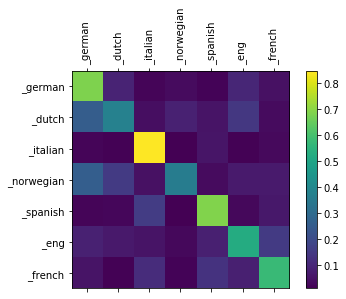

In [42]:
print_conf_matrix(conf_matrix)

In [0]:
def predict(name, k=3):
  tensor_name = name2tensor(name)
  with torch.no_grad():
    hidden = torch.zeros(1, hidden_size)
    for i in range(tensor_name.shape[0]):
      hidden, output = rnn(tensor_name[i], hidden)
    top_ns, top_is = output.topk(k)
  for i in range(k):
    print(all_categories_names[top_is[0][i]])  


In [47]:
predict('datando')

_spanish
_italian
_dutch
